Load saved run artifacts and reproduce plots without re-running learning.

Usage:
    python3 replay_plots.py run_artifacts.pkl
    python3 replay_plots.py run_artifacts.pkl --rebuild-interp
    python3 replay_plots.py run_artifacts.pkl --rebuild-interp --debug

If no filename is provided the script looks for `run_artifacts.pkl` in the
current working directory.

Notes:
- Rebuilding LinearNDInterpolator can be very slow. This script skips it by
  default because it is not used for plotting in this file.
- If you REALLY need interpolants for something else, pass --rebuild-interp.

In [ ]:
from __future__ import annotations

import sys
sys.argv = ["replay_plots.py"]
from pathlib import Path
import time
import math

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay

from save_run_artifacts import load_run

from functions.general.lifting_function import lifting_function
from functions.stateSpaceModel.build_A_adaptive import build_A_adaptive
from functions.stateSpaceModel.build_B_numgrad_3D import build_B_numgrad_3D
from functions.stateSpaceModel.build_C import build_C
from functions.stateSpaceModel.compute_eigenf_adaptive import compute_eigenf_adaptive
from main import rk4_step, rk4_step_linear, f_u



def make_phi_hat(points: np.ndarray, phi_vals: np.ndarray, debug: bool = False):
    """Recreate callable interpolants from saved points and values.

    points: shape (n_samples, 3)   (your case: ndim=3)
    phi_vals: shape (n_features, n_samples)

    Returns list of callables that accept:
      - a single point shape (3,)
      - or an array of points shape (n_pts, 3)
    and returns a 1D array of interpolated values (n_pts,).
    """
    points = np.asarray(points, dtype=float)
    phi_vals = np.asarray(phi_vals, dtype=float)

    if points.ndim != 2:
        raise ValueError(f"`points` must be 2D (n_samples, ndim). Got {points.shape}")
    if phi_vals.ndim != 2:
        raise ValueError(f"`phi_vals` must be 2D (n_features, n_samples). Got {phi_vals.shape}")
    if points.shape[0] != phi_vals.shape[1]:
        raise ValueError(
            f"Mismatch: points has {points.shape[0]} samples but phi_vals has {phi_vals.shape[1]}."
        )

    # Expensive step: build triangulation ONCE, reuse it for each feature.
    t0 = time.perf_counter()
    tri = Delaunay(points)
    if debug:
        print(f"[debug] Delaunay built in {time.perf_counter() - t0:.3f} s")

    phi_hat = []
    for ii in range(phi_vals.shape[0]):
        interp = LinearNDInterpolator(tri, phi_vals[ii, :])

        # default-arg capture so each fn uses its own interp
        def fn(x, interp=interp):
            x_arr = np.asarray(x, dtype=float)

            # Accept (3,) or (n,3)
            if x_arr.ndim == 1:
                if x_arr.shape[0] != points.shape[1]:
                    raise ValueError(f"Point must have shape ({points.shape[1]},), got {x_arr.shape}")
                vals = interp(x_arr)  # scalar
                return np.atleast_1d(vals).astype(float)
            elif x_arr.ndim == 2:
                if x_arr.shape[1] != points.shape[1]:
                    raise ValueError(f"Points must have shape (n,{points.shape[1]}), got {x_arr.shape}")
                vals = interp(x_arr)  # (n,)
                return np.asarray(vals, dtype=float).reshape(-1)
            else:
                raise ValueError(f"x must be 1D or 2D, got shape {x_arr.shape}")

        phi_hat.append(fn)

    return phi_hat


def plot_phase_portrait(Traj: list, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    for row in Traj:
        for traj in row:
            if traj is None:
                continue
            ax.plot(traj[0, :], traj[1, :], color=(0.7, 0.7, 0.7), linewidth=0.8)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_title("Phase portrait (x1,x2)")
    ax.grid(True)
    ax.set_aspect("equal")
    return ax


In [6]:
args = sys.argv[1:]

# crude CLI parsing (because apparently we love simplicity until we don't)
rebuild_interp = "--rebuild-interp" in args
debug = "--debug" in args
args = [a for a in args if a not in ("--rebuild-interp", "--debug")]

path = args[0] if len(args) > 0 else "run_artifacts.pkl"
p = Path(path)
if not p.exists():
    raise FileNotFoundError(f"Artifacts file not found: {p.resolve()}")

t0 = time.perf_counter()
artifacts = load_run(str(p))
if debug:
    print(f"[debug] Loaded artifacts in {time.perf_counter() - t0:.3f} s")

In [7]:
# Unpack commonly used artifacts
A = artifacts["A"]
Ac = artifacts["Ac"]
C = artifacts["C"]
nEig = artifacts["nEig"]
gc = artifacts["gc"]
h = artifacts["h"]
interp_points = artifacts["interp_points"]
#phi_vals = artifacts["phi_vals"]
data_uncontrolled = artifacts["data_uncontrolled"]
Traj = artifacts["Traj"]
Traj_t = artifacts["Traj_t"]
Traj_x1 = artifacts["Traj_x1"]
Traj_x2 = artifacts["Traj_x2"]
min_x1 = artifacts["min_x1"]
max_x1 = artifacts["max_x1"]
min_x2 = artifacts["min_x2"]
max_x2 = artifacts["max_x2"]
n_states = artifacts["n_states"]
n_total_states = artifacts["n_total_states"]

# Compute discrete lambdas as the diagonal elements of A
lambdas_vec = np.diag(A)                    # flat vector
split_idx = np.cumsum(nEig)[:-1]            # e.g. [10] when nEig=[10,10]
lambdas = np.split(lambdas_vec, split_idx)

# Compute continuous lambdas as the diagonal elements of A
lambdas_vec = np.diag(Ac)                    # flat vector
split_idx = np.cumsum(nEig)[:-1]            # e.g. [10] when nEig=[10,10]
lambdas_c = np.split(lambdas_vec, split_idx)

In [8]:

phi_vals, phi_hat = compute_eigenf_adaptive(lambdas, Traj_t, data_uncontrolled)
liftingFunction = lambda x: lifting_function(np.asarray(x, dtype=float).reshape(-1, 1), phi_hat)

<Axes: title={'center': 'Phase portrait (x1,x2)'}, xlabel='$x_1$', ylabel='$x_2$'>

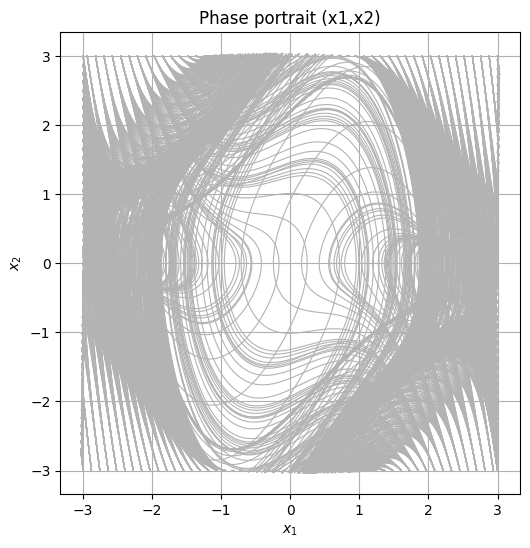

In [9]:
# Reconstruct interpolants ONLY if explicitly requested.
# In this script, phi_hat is not used for plotting, so default is OFF.
if rebuild_interp:

    if debug:
        print(f"[debug] points.shape = {interp_points.shape}, phi_vals.shape = {phi_vals.shape}")

    t1 = time.perf_counter()
    phi_hat = make_phi_hat(interp_points, phi_vals, debug=debug)
    if debug:
        print(f"[debug] Built {len(phi_hat)} interpolants in {time.perf_counter() - t1:.3f} s")

# Phase portrait
fig, ax = plt.subplots(figsize=(6, 6))
plot_phase_portrait(Traj, ax=ax)

In [15]:
# System dynamics -- Van der Pol oscillator (from modelAnalysis.py)
#   dot x1 = x2
#   dot x2 = mu*(1 - x1^2)*x2 - x1 + (1 + a*x1^2)*tanh(b*u)
mu = 1.0
a = 0.5
b = 1.0

def f_u(t, x, u):
        # x is the augmented state [x1, x2, x3]
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        f1 = x2
        f2 = mu * (1.0 - x1 ** 2) * x2 - x1 + (1.0 + a * x1 ** 2) * math.tanh(b * x3)
        f3 = u  # dot x3 = u (input drives the third state)
        return np.array([f1, f2, f3], dtype=float)

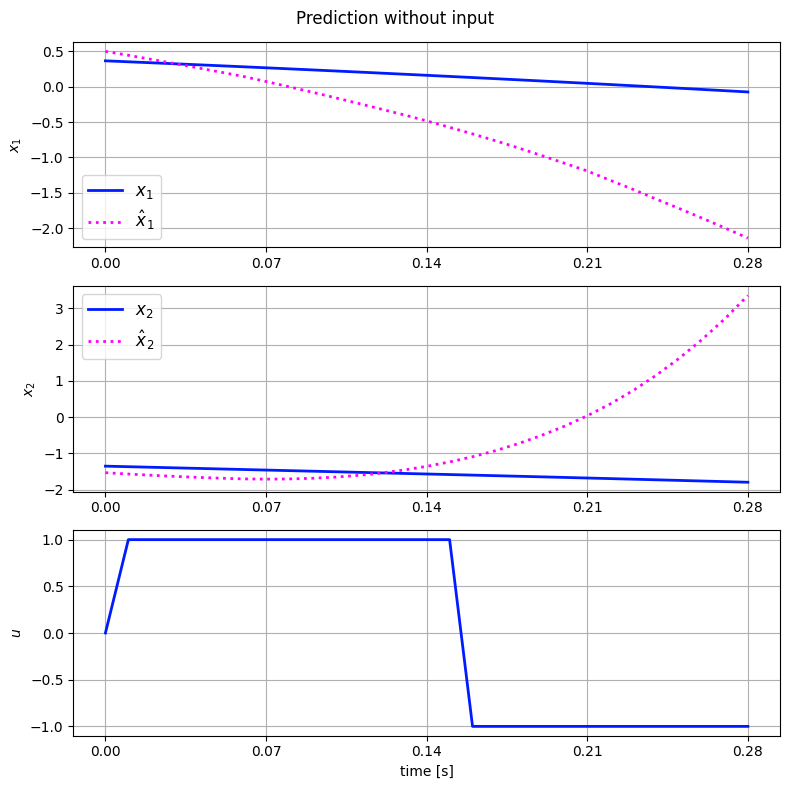

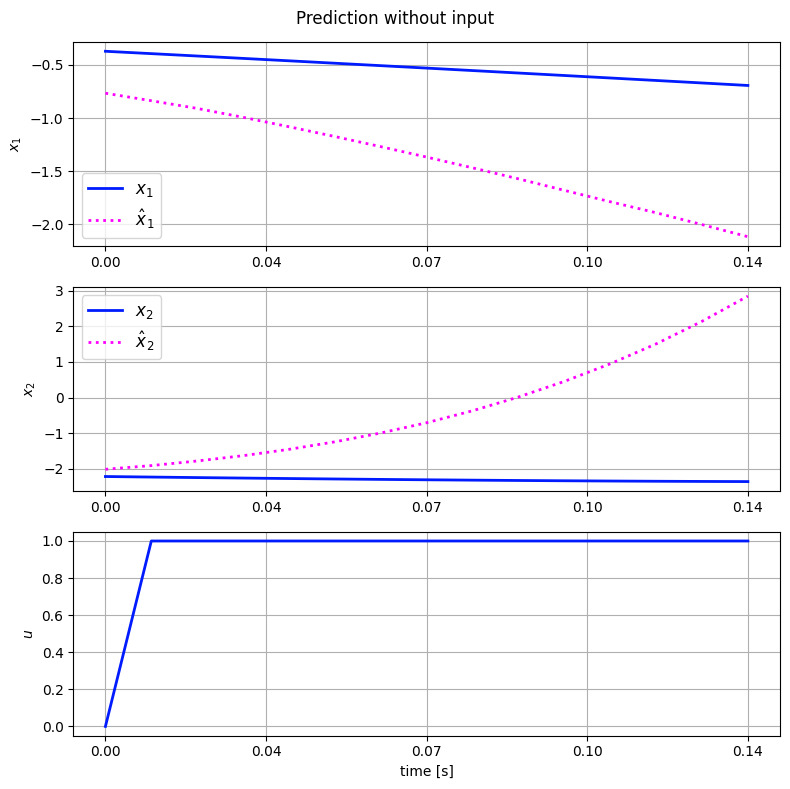

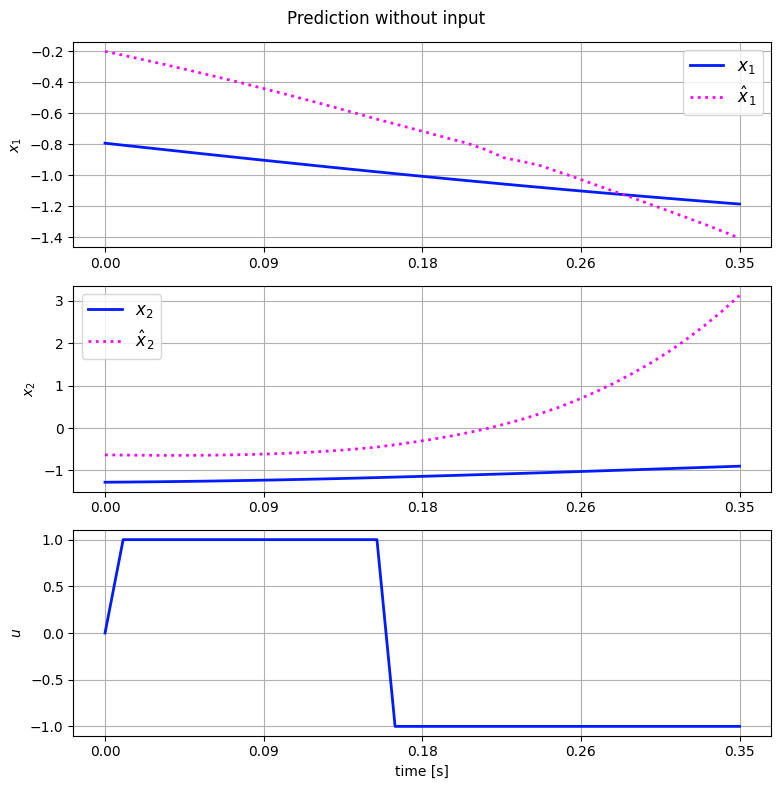

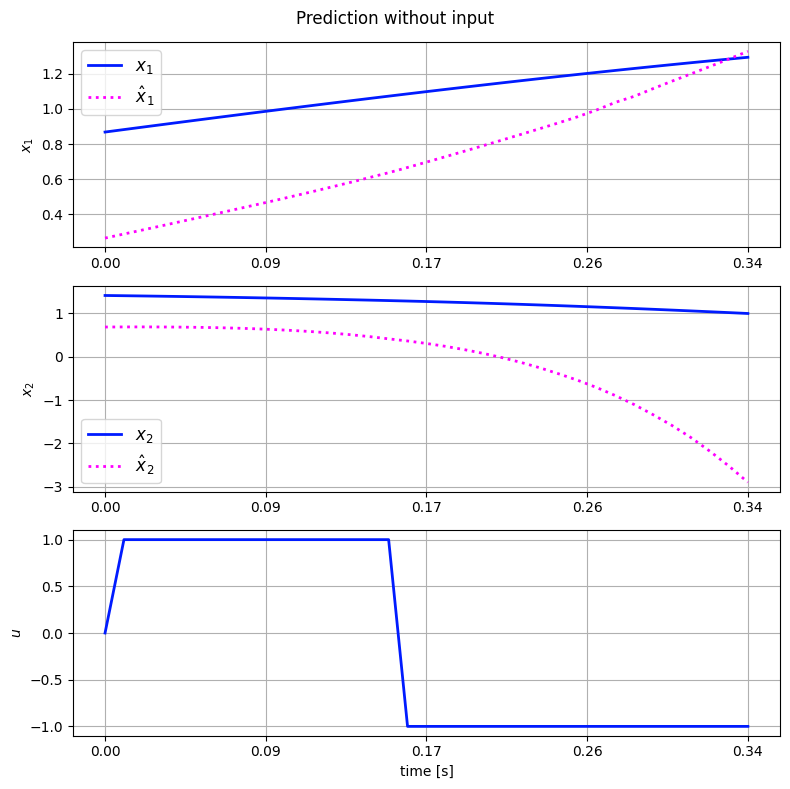

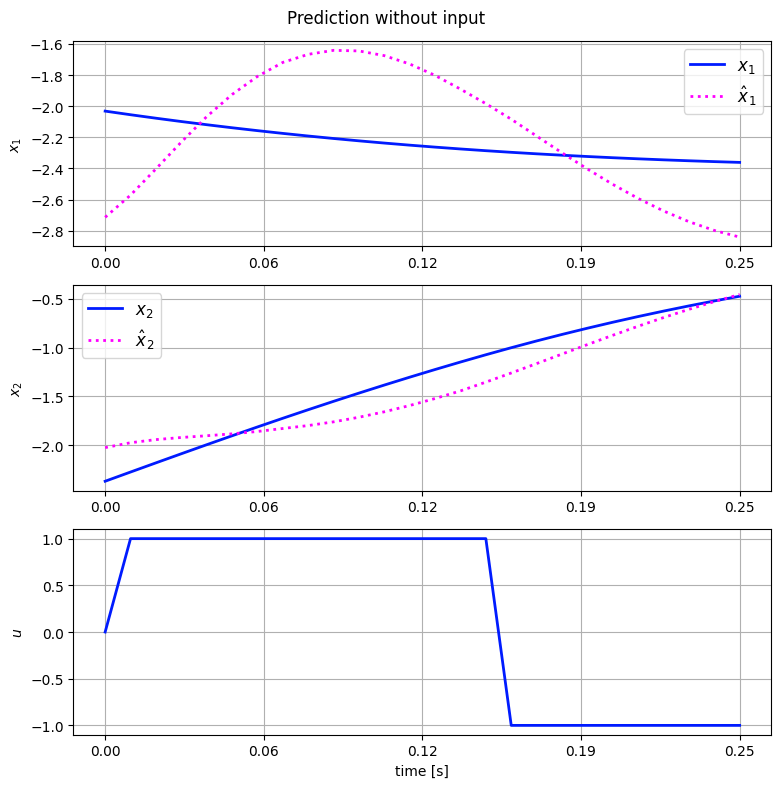

In [ ]:
# Make new plots here as needed...
PREDICT_SINGLE_TRAJ = True
u_dt = lambda k: (-1.0) ** (round(k / 30))

if PREDICT_SINGLE_TRAJ:
    CHECK_ON_TRAINING = True
    dt_pred = 0.01

    # initial condition generator now returns the augmented state [x1,x2,x3]
    x0_fcn = lambda k: np.array(
        [
            min_x1 + (max_x1 - min_x1) * np.random.rand(),
            min_x2 + (max_x2 - min_x2) * np.random.rand(),
            0.0,
        ],
        dtype=float,
    )

    if CHECK_ON_TRAINING:
        Tpred = 1.0
        u = lambda t, k: 0.0
        title_string = "Prediction without input"
    else:
        Tpred = 2.0
        Amp = 1.0
        w = 10.0
        u = lambda t, k: Amp * math.sin(w * t)
        title_string = "Prediction with input"

    Npred = int(Tpred / dt_pred)
    kmax = 5

    for kk in range(kmax):
        x_initial = x0_fcn(kk)
        # lifting function expects the full augmented state (x1,x2,u) now
        # so pass the complete state vector (the input component is 0 for
        # the initial condition here).
        z0 = liftingFunction(x_initial).reshape(-1)

        # Xtrue stores the full augmented nonlinear trajectory; X_gra holds
        # the predicted physical states recovered from the Koopman model
        Xtrue = np.zeros((n_total_states, Npred + 1), dtype=float)
        X_gra = np.zeros((n_states, Npred + 1), dtype=float)
        Utrue = np.zeros(Npred + 1, dtype=float)
        Z_gra = np.zeros((np.sum(nEig), Npred + 1), dtype=complex)

        Z_gra[:, 0] = z0
        Xtrue[:, 0] = x_initial
        X_gra[:, 0] = np.real(C @ z0)
        Utrue[0] = u(0.0, kk)

        order = 4
        ii = 1
        while (
            ii <= Npred
            and (min_x1 + 0.2) <= X_gra[0, ii - 1] <= (max_x1 - 0.2)
            and (min_x2 + 0.2) <= X_gra[1, ii - 1] <= (max_x2 - 0.2)
        ):
            Utrue[ii] = u_dt(ii)
            Xtrue[:, ii] = rk4_step(f_u, 0.0, Xtrue[:, ii - 1], Utrue[ii], dt_pred)

            B_numgrad = build_B_numgrad_3D(h, phi_hat, np.concatenate((X_gra[:, ii-1], [Utrue[ii]])), nEig, gc)
            B_vec = np.asarray(B_numgrad).reshape(-1)
            Z_gra[:, ii] = rk4_step_linear(Z_gra[:, ii - 1], Ac, B_vec, Utrue[ii], dt_pred)
            X_gra[:, ii] = np.real(C @ Z_gra[:, ii])

            ii += 1

        time_ticks = np.linspace(0, ii - 1, 5)
        fig_pred, axes = plt.subplots(3, 1, figsize=(8, 8))

        axes[0].plot(Xtrue[0, :ii], linewidth=2, color="#001BFF", label=r"$x_1$")
        axes[0].plot(X_gra[0, :ii], linewidth=2, linestyle=":", color="magenta", label=r"$\hat x_1$")
        axes[0].legend(fontsize=12)
        axes[0].grid(True)
        axes[0].set_xticks(time_ticks)
        axes[0].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[0].set_ylabel(r"$x_1$")

        axes[1].plot(Xtrue[1, :ii], linewidth=2, color="#001BFF", label=r"$x_2$")
        axes[1].plot(X_gra[1, :ii], linewidth=2, linestyle=":", color="magenta", label=r"$\hat x_2$")
        axes[1].legend(fontsize=12)
        axes[1].grid(True)
        axes[1].set_xticks(time_ticks)
        axes[1].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[1].set_ylabel(r"$x_2$")

        axes[2].plot(Utrue[:ii], linewidth=2, color="#001BFF", label=r"$u$")
        axes[2].grid(True)
        axes[2].set_xticks(time_ticks)
        axes[2].set_xticklabels([f"{t*dt_pred:.2f}" for t in time_ticks])
        axes[2].set_xlabel("time [s]")
        axes[2].set_ylabel(r"$u$")

        fig_pred.suptitle(title_string)
        plt.tight_layout()

        # persist prediction figure to disk so it can be reviewed later
        try:
            fig_pred.savefig(f"prediction_{kk}.png", dpi=150)
        except Exception:
            pass

plt.show()